# Machine Analysis Primer For b278 VVV Tile

## b278 Vs Itself (with 10 kfolds)

- **author:** JB Cabral (<jbc.develop@gmail.com>)

In [1]:
% matplotlib inline

import os
import tempfile

import numpy as np

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set()

import sklearn
from sklearn import feature_selection as fs
from sklearn import preprocessing as prp
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from IPython import display as d

from lime import lime_tabular as lt

from joblib import Memory

from libs import container

pd.options.mode.chained_assignment = None 

memory = Memory(cachedir="cache", verbose=0)

## 1. Load Data

In [2]:
path = "/home/data/carpyncho/stored/samples/b278_sample.npy"
df = pd.DataFrame(np.load(path))

##  2. Preprocess

### 2.1. Discretize the classes

In [3]:
classes = set(df.ogle3_type)
sclasses_names = set(c.split("-", 1)[0] for c in classes)
classes = dict(zip(sorted(classes), range(len(classes))))
sclasses = dict(zip(sorted(sclasses_names), range(len(sclasses_names))))

df["cls"] = df.ogle3_type.apply(classes.get)
df["scls"] = df.ogle3_type.apply(lambda v: sclasses.get(v.split("-", 1)[0]))
    
d.display(d.Markdown("### Classes"))
d.display(classes)

d.display(d.Markdown("### Simplified Classes"))
d.display(sclasses)

### Classes

{'': 0,
 'Cep-1': 1,
 'Cep-F': 2,
 'LPV-Mira': 3,
 'LPV-OSARG': 4,
 'LPV-SRV': 5,
 'RRLyr-RRab': 6,
 'RRLyr-RRc': 7,
 'RRLyr-RRd': 8,
 'T2Cep-BLHer': 9,
 'T2Cep-RVTau': 10,
 'T2Cep-WVir': 11}

### Simplified Classes

{'': 0, 'Cep': 1, 'LPV': 2, 'RRLyr': 3, 'T2Cep': 4}

### 2.2. Removes all low-variance and "bad" features

In [4]:
# RR lyrae
df = df[df.scls.isin([3, 0])]

# columns with nan and null
df = df.loc[:, ~df.isnull().any()]

X_columns = df.columns[~df.columns.isin(["id", "cls", "scls", "ogle3_type"])]
X_columns = X_columns[~X_columns.str.startswith("Signature_")]
y = df["scls"].values

# low variance
vt = fs.VarianceThreshold()
vt.fit(df[X_columns].values, y)

print "total features:", len(X_columns)

total features: 58


In [5]:
X_columns = X_columns[vt.get_support()]
X_scaled = prp.StandardScaler().fit_transform(df[X_columns].values)

/home/jbcabral/projects/paper_b278/local/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


### 2.3 Selected features

In [6]:
d.display(d.HTML(
    "<ol>" +
    "".join("<li>{}</li>".format(c) for c in X_columns) +
    "</ol>"))

## 3. Machine Learning

The next function fit the classifier with kfolds (`default=10`) print a and retrieve:

- **fpr:** False positive rates
- **tpr:** True positive rates
- **thresh:** Decreasing thresholds on the decision function used to compute fpr and tpr
- **roc_auc:** Area under curve of ROC Curve.
- **y_test:** Array of all classes of testing samples.
- **predictions:** The prediction clases for the testing samples.
- **probabilities:** Predicted classes probabilities for tests.
- **confussion_matrix:** Confusion matrix to evaluate the accuracy of a classification

In [7]:
def experiment(clf, x, y, nfolds=10, printing=True):
    skf = StratifiedKFold(n_splits=nfolds)
    
    probabilities = None
    predictions = np.array([])
    y_testing = np.array([])
    
    for train, test in skf.split(x, y):
        
        x_train = x[train]
        y_train = y[train]
        clf.fit(x_train, y_train)

        x_test = x[test]
        y_test = y[test]
        pr = clf.predict(x_test)
        probs = clf.predict_proba(x_test)  #[:, 0]
        
        probabilities = (
            probs if probabilities is None else
            np.vstack([probabilities, probs]))
        predictions = np.hstack([predictions, pr])
        y_testing = np.hstack([y_testing, y_test])

    if printing: 
        print metrics.classification_report(y_testing, predictions)
        
    fpr, tpr, thresholds = metrics.roc_curve(
            y_testing, 1.-probabilities[:,0], pos_label=3)
    prec_rec_curve = metrics.precision_recall_curve(
        y_testing, 1.- probabilities[:,0], pos_label=3)
    roc_auc = metrics.auc(fpr, tpr)
    
    return container.Container({
            'fpr': fpr, 
            'tpr': tpr, 
            'thresh': thresholds, 
            'roc_auc': roc_auc, 
            'prec_rec_curve': prec_rec_curve,
            'y_test': y_testing, 
            'predictions': predictions,
            'probabilities': probabilities, 
            'confusion_matrix': metrics.confusion_matrix(y_testing, predictions)})


def roc(results):
    cmap = cm.get_cmap("plasma")
    colors = iter(cmap(np.linspace(0, 1, len(results))))

    for res  in results:
        cname = "Vs.{}".format(res.test_name)
        color = next(colors)
        label = '%s (area = %0.2f)' % (cname, res["roc_auc"])
        plt.plot(res["fpr"], res["tpr"], color=color, label=label)

    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### 3.1. SVM - Linear

Execute a **SVM** with a **linear kernel**. All the default parameters are documented here: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [8]:
%time svc_linear = experiment(svm.SVC(kernel='linear', probability=True), X_scaled, y)

             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99     20000
        3.0       0.90      0.33      0.48       424

avg / total       0.98      0.99      0.98     20424

CPU times: user 3min 50s, sys: 2.39 s, total: 3min 52s
Wall time: 3min 52s


### 3.2 SVM - Polynomic

Execute a **SVM** with a **polynomic kernel**. All the default parameters are documented here: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [9]:
%time svc_poly = experiment(svm.SVC(kernel='poly', probability=True), X_scaled, y)

             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99     20000
        3.0       0.86      0.32      0.46       424

avg / total       0.98      0.98      0.98     20424

CPU times: user 2min 41s, sys: 1.8 s, total: 2min 43s
Wall time: 2min 43s


### 3.3. Random Forest

Execute a **Random Forest** with **500 c45** trees. All the default parameters are documented here: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [10]:
%time rf = experiment(RandomForestClassifier(n_estimators=500, criterion="entropy"), X_scaled, y)

             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99     20000
        3.0       0.97      0.40      0.57       424

avg / total       0.99      0.99      0.98     20424

CPU times: user 8min 42s, sys: 57 ms, total: 8min 42s
Wall time: 8min 42s


### 3.4. KNN

KNN with **3** neightbors ad weights determined by the **distance**. Docs: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [11]:
%time knn = experiment(KNeighborsClassifier(n_neighbors=3, weights='distance'), X_scaled, y)

             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99     20000
        3.0       0.64      0.31      0.42       424

avg / total       0.98      0.98      0.98     20424

CPU times: user 2min 5s, sys: 75.7 ms, total: 2min 5s
Wall time: 2min 6s


## 4. ROC

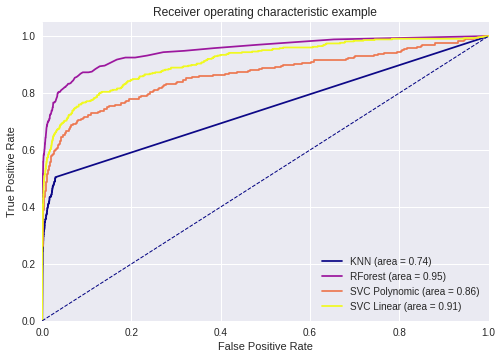

In [12]:
results = {
    "KNN": knn, 
    "RForest": rf,
    "SVC Linear": svc_linear,
    "SVC Polynomic": svc_poly
}

cmap = cm.get_cmap("plasma")
colors = iter(cmap(np.linspace(0, 1, len(results))))

for cname, res  in results.items():
    color = next(colors)
    label = '%s (area = %0.2f)' % (cname, res["roc_auc"])
    plt.plot(res["fpr"], res["tpr"], color=color, label=label)

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()